In [1]:
# ---- Nested function ---- #
import os
import pandas as pd
import wfdb
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from pprint import pprint
from collections import Counter
import math
from copy import deepcopy
import random

# ---- Scipy ---- #
from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt

# ---- PyTorch ---- #
import torch
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.nn.functional import softmax
from torch.nn.parallel import DistributedDataParallel
from pytorchtools import EarlyStopping
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import tensorboard
from tensorboardX import SummaryWriter

# ---- Scikit Learn ---- #
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold


# ---- Matplotlib ---- #
import matplotlib.pyplot as plt

# ---- Summary ---- #
import pytorch_model_summary


1. Transformer Encoder만 써서 12 Lead Channel의 Latent Vector를 FC Layer로 분류하는 것

2. 사실 12 Lead의 데이터는 Image나 다름없음 대신 data의 개수가 5000개니까 이를 적절하게 patch 개수로 나눠주면 ViT로 분류될 수 있을 것이라고 생각

### Data Load

In [2]:
x_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_train.npy")
y_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_train.npy")
x_valid = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_valid.npy")
y_valid = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_valid.npy")
x_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_test.npy")
y_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_test.npy")

In [3]:
x_train.shape, x_test.shape

((13976, 12, 5000), (4368, 12, 5000))

### Data Scaling

각 Lead 별로 Z-Score Normalization을 하는게 좋을듯

Ref : Multi-Label ECG Classification using Temporal Convolutional Neural Network

# Fit Transform

lead_Scaler = [StandardScaler() for _ in range(12)]
for i, xt in enumerate(x_train):
    for j in range(12):
        r_xt = xt[j].reshape(-1,1)
        r_xt = lead_Scaler[j].fit_transform(r_xt)
        r_xt = r_xt.reshape(1,-1)
        x_train[i][j] = r_xt
        
for i, xt in enumerate(x_test):
    for j in range(12):
        r_xt = xt[j].reshape(-1,1)
        r_xt = lead_Scaler[j].transform(r_xt)
        r_xt = r_xt.reshape(1,-1)
        x_test[i][j] = r_xt

[1. 0. 0. 0. 0.]


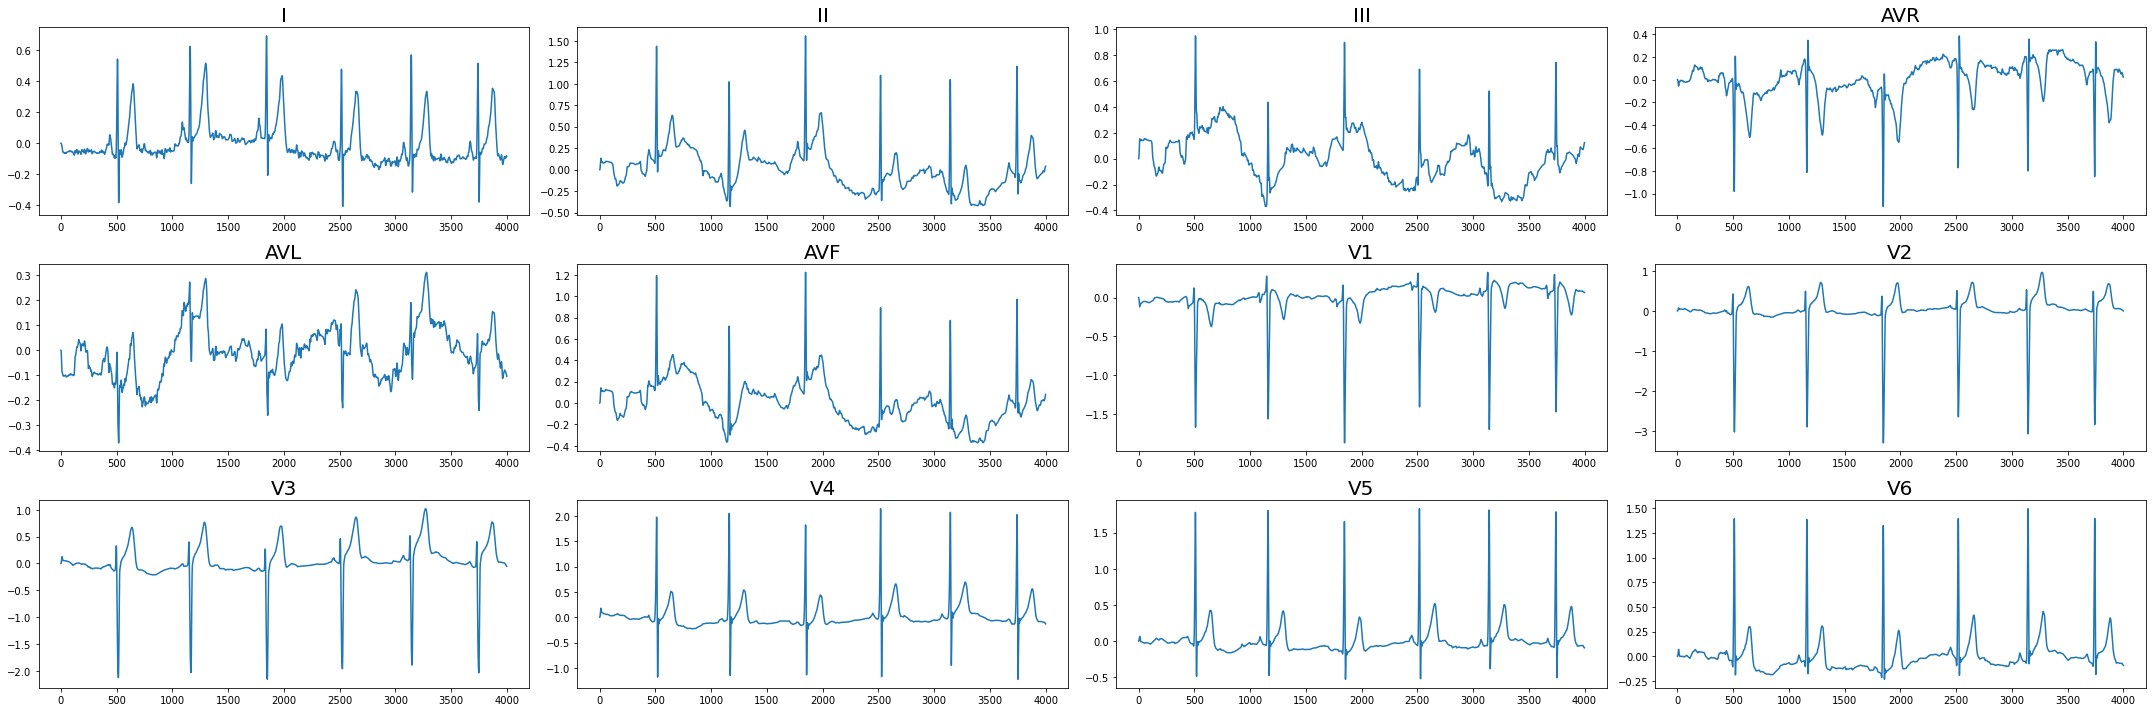

In [4]:
fig = plt.figure(figsize=(30,10))
leadNames = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
print(y_train[1])
for i,lead in enumerate(leadNames):
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_title(leadNames[i], fontsize=20)
    ax1.plot(x_train[1][i][0:4000])
fig.tight_layout()

### Get DataLoader

In [12]:
def get_DataLoader(x, y, batch, num_workers, shuffle=False):
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=shuffle)
    return dataloader

batch_size = 32
num_workers = 2

train_loader = get_DataLoader(x_train, y_train, batch=32, num_workers=num_workers, shuffle=True)
val_loader = get_DataLoader(x_valid, y_valid, batch=16, num_workers=num_workers, shuffle=True)
test_loader = get_DataLoader(x_test, y_test, batch=16, num_workers=num_workers, shuffle=True)

### Model Architecture

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class ViTEmbeddings(nn.Module):
    def __init__(self, in_channel, emb_size, patch_size, dropout=0.0):
        super().__init__()
        
        self.patch_size= patch_size
        self.emb_size= emb_size
        
        self.patch_embeddings = nn.Sequential(
            nn.Conv1d(in_channel, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange("b e (p) -> b (p) e")
        )
        self.dropout = nn.Dropout(dropout)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.emb_size))
        num_patches = 5000//patch_size
        self.positions = nn.Parameter(torch.randn(1, num_patches +1, self.emb_size)) ## Num Patches....어케하지
    
    def forward(self, x):
        input_shape = x.shape # B C L
#         print("Input Shape :",input_shape)
        embeddings = self.patch_embeddings(x)
#         print("Class Embedding Shape :", embeddings.shape)
        # 16 768 250 = Batch, emb_size, patch / Rearrange -> Batch, Patch, Emb_size
        cls_token = repeat(self.cls_token, "() n e -> b n e", b=input_shape[0])
        x = torch.cat([cls_token, embeddings], dim=1)
        x += self.positions
        return x
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, attention_bias=True ,attention_dropout=0.0, sd_survival_probability=1.0, activation="gelu", dropout=0.0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        
        self.layerNorm = nn.LayerNorm(emb_size)
#         self.MATT = nn.MultiheadAttention(emb_size, num_heads, dropout=dropout, bias=attention_bias)
        
        self.qkv = nn.Sequential( # QKV Embedding
            nn.Linear(emb_size, emb_size),
            Rearrange("b n (h d) -> b h n d", h=num_heads)
        )
        self.att_Drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x):
        q = self.qkv(x)
        k = self.qkv(x)
        v = self.qkv(x)
        
#         print("Q shape",q.shape)
#         print("K shape",k.shape)
#         print("V shape",v.shape)
        
        
        # Attention Score
        dot_product_value = torch.einsum('bhqd, bhkd -> bhqk', q, k)
#         print("Dot product Value ",dot_product_value.shape)
        scaling = math.sqrt(self.emb_size)        
        att = softmax(dot_product_value, dim=-1)/scaling
        att = self.att_Drop(att)
#         print("Att :",att.shape)
        
        # 
        out = torch.einsum("bhal, bhlv -> bhav", att, v)
#         print("Out :",out.shape)
        out = rearrange(out, "b h n d -> b n (h d)")
#         print("Out(Rearrange) :",out.shape)
        out = self.projection(out)
#         print("Out(Linear) :",out.shape)
        
        return out
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x 
        x = self.fn(x, **kwargs)
        x += res
        return x
class MLP(nn.Sequential):
    def __init__(self, emb_size: int = 768, expansion: int = 4, dropout=0.2):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(expansion * emb_size, emb_size)
        )
        
class EncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int=768, num_heads: int=6,f_expansion: int=4, f_dropout=0.0, dropout=0.1,**kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, attention_bias=True),
                nn.Dropout(dropout)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MLP(emb_size, expansion=f_expansion, dropout=f_dropout),
                nn.Dropout(dropout)
            ))
        )
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int=6, **kwargs):
        super().__init__(*[EncoderBlock(**kwargs) for _ in range(depth)])
        
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=5):
        super().__init__(
            Reduce("b n e -> b e", reduction="mean"),
            nn.Linear(emb_size, 256),
            nn.LayerNorm(256),
            nn.Linear(256, n_classes)
        )

class ViT(nn.Module):
    def __init__(self, in_channel: int= 12, patch_size: int= 20, emb_size: int= 768, num_heads: int= 6, n_classes: int= 5, depth: int= 6):
        super().__init__()
        self.in_channel = in_channel
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.n_classes = n_classes
        self.depth = depth
        
        self.Embeddings = ViTEmbeddings(in_channel, emb_size, patch_size)
        self.TransformerEncoder = TransformerEncoder(depth)
        self.ClassificationHead = ClassificationHead(emb_size, n_classes)
        
    def forward(self, x):
        embedding = self.Embeddings(x)
#         print("Embedding Shape :",embedding.shape)
        encoder_value = self.TransformerEncoder(embedding)
#         print("Transformer Result Shape :",encoder_value.shape)
        result = self.ClassificationHead(encoder_value)
#         print("Classification Shape :",result.shape)
        return result

In [16]:
# Model Summary
print(pytorch_model_summary.summary(ViT().to(device), torch.zeros(16, 12, 5000).to(device), show_input=False, show_hierarchical=True , batch_size=16, print_summary=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
   ViTEmbeddings-1      [16, 251, 768]         378,624         378,624
     ResidualAdd-2      [16, 251, 768]       1,184,256       1,184,256
     ResidualAdd-3      [16, 251, 768]       4,723,968       4,723,968
     ResidualAdd-4      [16, 251, 768]       1,184,256       1,184,256
     ResidualAdd-5      [16, 251, 768]       4,723,968       4,723,968
     ResidualAdd-6      [16, 251, 768]       1,184,256       1,184,256
     ResidualAdd-7      [16, 251, 768]       4,723,968       4,723,968
     ResidualAdd-8      [16, 251, 768]       1,184,256       1,184,256
     ResidualAdd-9      [16, 251, 768]       4,723,968       4,723,968
    ResidualAdd-10      [16, 251, 768]       1,184,256       1,184,256
    ResidualAdd-11      [16, 251, 768]       4,723,968       4,723,968
    ResidualAdd-12      [16, 251, 768]       1,184,256       1,184,256
    R

In [17]:
# Evaluate
from sklearn.metrics import multilabel_confusion_matrix, classification_report

label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

def Evaluate(model, test_loader):
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    logits_list = []
    gt_list = []
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
#             logits = logits.round()
            logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
#                 print(gt.astype(int))
                gt_list.append(gt.astype(int))
            
#             print("=======logits=======")
#             print(logits)
#             print("=======GT=======")
#             print(y.cpu().detach().numpy())
#             if step == 0:
#                 np.append()
#             np.concatenate((output_list, logits), axis=0)

    print(classification_report(gt_list, logits_list, target_names=label_names))

In [ ]:
seed = 100
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

writer = SummaryWriter("runs/vit")

# lr = 5e-5
# epoch = 40
# model = ViT()
criterion = nn.MultiLabelSoftMarginLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(patience=3, verbose=False)
# model.to(device)

loss_list=[]
val_loss_list = []

best_loss = np.inf
best_models = []

epoch = 150
lrs = [1e-5]
batchs = [16, 32, 64]

for i in range(1):
    for j in range(3):
        model=ViT()
        model.to(device)
        batch_s = batchs[j]
        optimizer = optim.Adam(model.parameters(), lr=lrs[i])
        train_loader = get_DataLoader(x_train, y_train, batch=batch_s, num_workers=num_workers, shuffle=True)
        
        print(f"EPOCH : {epoch}, BATCH : {batch_s}, LR : {lrs[i]}")
        for ep in range(epoch):
            train_bar = tqdm(train_loader)
            for step, (x,y) in enumerate(train_bar):
        #         print("step :",step, x.shape, "/", y.shape)
                x, y = x.to(device), y.to(device)
                
                model.train()
                logits = model(x)
                loss = criterion(logits, y)
                loss_list.append(loss.mean().item())

                optimizer.zero_grad()
                loss.mean().backward()
                optimizer.step()
                train_bar.desc = "Train Epoch[{}/{}] loss: {:.3f}".format(ep+1, epoch, loss.mean().item())

                writer.add_scalar(f"Training loss_{batch_s}", loss.mean(), ep * len(train_loader) + step)
#             loss_train = 0
#             with torch.no_grad():
#                 model.eval()
#                 loss_train = 0
#                 for step, (x,y) in enumerate(train_bar):
#                     x,y = x.to(device), y.to(device)

#                     logits = model(x)
#                     lt = criterion(logits, y)
#                     loss_train += lt.mean().item()

#             print(f"Train_Loss : {loss_train/len(train_loader)}")
#             if loss_train < best_loss:
#                 best_loss = loss_train
#                 best_models.append((model,ep))
            
            with torch.no_grad():
                model.eval()
                val_loss = 0.0
                val_bar = tqdm(val_loader)
                for v_step, (val_x, val_y) in enumerate(val_bar):
                    val_x, val_y = val_x.to(device), val_y.to(device)
                    val_logits = model(val_x)
                    loss_v = criterion(val_logits, val_y)
                    val_loss_list.append(loss_v.mean().item())
                    val_loss += loss_v.mean().item()
                    writer.add_scalar(f"Validation loss_{batch_s}", loss_v.mean(), ep * len(val_loader) + step)
            if best_loss > val_loss:
                print("Validation Loss Decrease.. Best Model, Best Loss update")
                print("Validation loss :",val_loss/len(val_loader))
                best_loss = val_loss
                torch.save(model.state_dict(), f"models/Saved_ViT_model_1119_{(round(val_loss,2)/len(val_loader))*100}_batch_{batch_s}.pth")

    #     early_stopping(loss.mean(), model)
    #     if early_stopping.early_stop:
    #         break
    #         if (i+1) % 5 == 0:
    #             logtis = logtis > 0.5
    #             acc = (logits == y).float().mean()
    #             print(f"EPOCH : {ep} : Loss : {loss.mean().item():.5f}, Acc : {acc.item():.5f}")
    
print("Evaluate")
Evaluate(model,test_loader)

  0%|                                                                          | 0/874 [00:00<?, ?it/s]

EPOCH : 150, BATCH : 16, LR : 1e-05


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.5327032751416507


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.4969059245227134


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.4599454998970032


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.4383047634744209


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.43443009461442084


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.41685639362629145


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.4159329087902966


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.411191265876979


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.40876383895743384


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.3963778184973486


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.3913905543007263


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.39073206429884316


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.3837743749221166


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.3835132799736441


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.38348929488767775


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.38034135354980486


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.37432941549444854


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.36660019393380916


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.36206265140886174


  0%|                                                                          | 0/874 [00:00<?, ?it/s]

Validation Loss Decrease.. Best Model, Best Loss update
Validation loss : 0.3557213244100684


100%|████████████████████████████████████████████████████████████████| 219/219 [00:05<00:00, 42.37it/s]


  0%|                                                                          | 0/437 [00:00<?, ?it/s]

EPOCH : 150, BATCH : 32, LR : 1e-05


100%|████████████████████████████████████████████████████████████████| 219/219 [00:05<00:00, 41.55it/s]


Train Epoch[145/150] loss: 0.071:  58%|█████████████████▌            | 255/437 [00:32<00:22,  7.93it/s]

In [19]:
print(len(best_models))

0


In [25]:
import warnings
warnings.filterwarnings('ignore')

idx = 0
for i in range(1):
    for j in range(1):
        print(f"=======LR : {lrs[i]} | BATCH : {batchs[j]} | MODEL IDX : {idx}========")
        Evaluate(best_models[idx], test_loader)
        idx+=1

  0%|                                                                            | 0/273 [00:00<?, ?it/s]

=======LR : 1e-05 | BATCH : 16 | MODEL IDX : 0========


100%|██████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.29it/s]

              precision    recall  f1-score   support

        NORM       0.75      0.76      0.76      1621
          MI       0.66      0.74      0.70      1322
        STTC       0.67      0.56      0.61      1077
         HYP       0.71      0.63      0.66      1044
          CD       0.71      0.36      0.48       535

   micro avg       0.70      0.66      0.68      5599
   macro avg       0.70      0.61      0.64      5599
weighted avg       0.70      0.66      0.67      5599
 samples avg       0.66      0.66      0.64      5599



In [28]:
torch.save(best_models[0].state_dict(), "models/Saved_ViT_model_mr51_nZ.pth")

In [21]:
model = ViT().to(device)
# model.load_state_dict(torch.load("Best_Saved_ViT_model_f192.pth"))
model.load_state_dict(torch.load("models/Saved_ViT_model_1119_35.57077625570776_batch_16.pth"))

<All keys matched successfully>

### Confusion Matrix

In [22]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score,classification_report
label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']
logits_list = []
gt_list = []
def extract_metrix(idx ,lr, batch ,model, test_loader):
    global logtis_list, gt_list
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
    #             logits = logits.round()
            logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
    #                 print(gt.astype(int))
                gt_list.append(gt.astype(int))
    print(f"==================== lr : {lr} | Batch : {batch} | Model IDX : {idx} ====================")
    print(f"Exact Match Ratio, MR : : {accuracy_score(gt_list, logits_list)}")
    print(f"Hamming Loss : {hamming_loss(gt_list, logits_list)}")
    print(classification_report(gt_list, logits_list, target_names=label_names))
    MR = np.all(np.array(logits_list) == np.array(gt_list), axis=1).mean()

In [23]:
extract_metrix(0, 1e-5, 16, model, test_loader)

100%|████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.99it/s]

==================== lr : 1e-05 | Batch : 16 | Model IDX : 0 ====================
Exact Match Ratio, MR : : 0.45444139194139194
Hamming Loss : 0.1538919413919414
              precision    recall  f1-score   support

        NORM       0.82      0.75      0.78      1717
          MI       0.81      0.44      0.57      1222
        STTC       0.81      0.36      0.50      1083
         HYP       0.79      0.50      0.61      1016
          CD       0.79      0.36      0.50       558

   micro avg       0.81      0.52      0.64      5596
   macro avg       0.80      0.48      0.59      5596
weighted avg       0.81      0.52      0.62      5596
 samples avg       0.58      0.53      0.55      5596




/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


idx = 0
for i in range(3):
    for j in range(3):
        extract_metrix(idx, lrs[i], batchs[j], best_models[idx], test_loader)
        idx+=1

In [24]:
label_names = np.array(['NORM', 'MI', 'STTC', 'HYP', 'CD'])
multi_label_cf = multilabel_confusion_matrix(gt_list, logits_list)

In [25]:
multi_label_cf

array([[[2365,  286],
        [ 431, 1286]],

       [[3017,  129],
        [ 682,  540]],

       [[3193,   92],
        [ 688,  395]],

       [[3218,  134],
        [ 508,  508]],

       [[3755,   55],
        [ 356,  202]]])

In [26]:
logits_list, gt_list = np.array(logits_list), np.array(gt_list)

In [27]:
logits_list.shape, gt_list.shape

((4368, 5), (4368, 5))

In [28]:
# NORM ACC
NORM_CM = multi_label_cf[0]
NORM_ACC = (NORM_CM[0][0]+NORM_CM[1][1])/((NORM_CM[0][0]+NORM_CM[0][1])+(NORM_CM[1][0]+NORM_CM[1][1]))

ACC = 0
for i in range(5):
    CM = multi_label_cf[i]
    
    TP = CM[0][0]
    P = CM[0][0]+CM[0][1]
    N = CM[1][0]+CM[1][1]
    TN = CM[1][1]
    C_ACC = ((TP+TN)/(P+N))*100
    ACC += C_ACC
    print(f"{label_names[i]} : {round(C_ACC,2)}%")

print(f"Total ACC (MEAN) {round(ACC/5,2)}%")

NORM : 83.59%
MI : 81.43%
STTC : 82.14%
HYP : 85.3%
CD : 90.59%
Total ACC (MEAN) 84.61%
